In [339]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.colorizer as mcolorizer

from mpl_toolkits.mplot3d import Axes3D, art3d

import cmocean

import homeomorphism_helpers as hh
from homeomorphism_helpers import fs

from papercolors import colordict as pcd
import coords

import numpy as np

In [288]:
verts = [[0, 0, -2 ],
         [-1, -1, -1], 
         [1, -1,  -1], 
         [1, 1,  -1 ], 
         [-1, 1, -1],
         [-1, -1, 1], 
         [1, -1, 1 ],
         [1, 1, 1], 
         [-1, 1, 1]]
V = .7 * np.array(verts) 
sides = {'TOP': [V[5], V[6], V[7], V[8]], 
         'F1': [V[1], V[2], V[6], V[5]], 
         'F2': [V[2], V[3], V[7], V[6]],
         'F3': [V[3], V[4], V[8], V[7]], 
         'F4': [V[4], V[1], V[5], V[8]], 
         'BOTTOM':[V[1], V[2], V[3], V[4]]}
cube_front = list(sides[s] for s in ['TOP', 'F1', 'F2'])

In [369]:
data = hh.get_data("nydata_2022.parquet")
df = data['df']
dates = data['dates']
lons = data['lons']
lats = data['lats']

nygeo, nyshp = hh.get_mapdata("nydata.csv", 's_22mr22.zip', hh.airports['map_date'])

[(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]

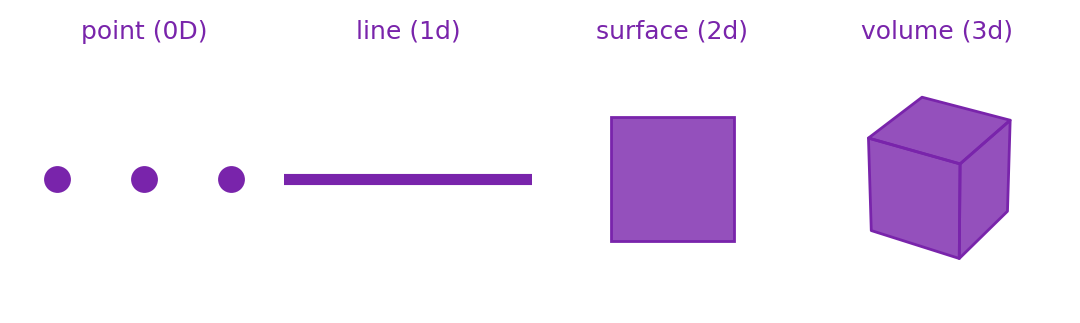

In [290]:
fig, axd = plt.subplot_mosaic([['dot', 'line', 'plane','cube']], 
                              figsize=(6, 1.5), layout='compressed', 
                              per_subplot_kw={'cube':{'projection':'3d'}})
for an in axd:
    axd[an].set(xlim=(0,1), ylim=(0,1), aspect='equal', xticklabels=[], yticklabels=[])
    axd[an].axis('off')
dot = axd['dot'].scatter([.15, .5, .85], [.5]*3, color=pcd['base'], s=75) 
axd['dot'].set_title("point (0D)", color=pcd['base'], size=fs['small'])
line = axd['line'].axhline(.5, color=pcd['base'], lw=4)
axd['line'].set_title("line (1d)", color=pcd['base'], size=fs['small'])

alpha =  .8
plane = mpatches.Rectangle((.25, .25), .5, .5, facecolor=(pcd['base'], alpha), edgecolor=pcd['base'])
axd['plane'].add_artist(plane)
axd['plane'].set_title('surface (2d)', color=pcd['base'], size=fs['small'])
axd['cube'].set_title('volume (3d)', color=pcd['base'], size=fs['small'])


collection = art3d.Poly3DCollection(cube_front, closed=True, edgecolor=pcd['base'], facecolor=(pcd['base'], alpha))
axd['cube'].add_collection(collection)
axd['cube'].set_aspect('equalxy')
axd['cube'].set(xlim=(-1,1), ylim=(-1, 1), zlim=(-1, 1))


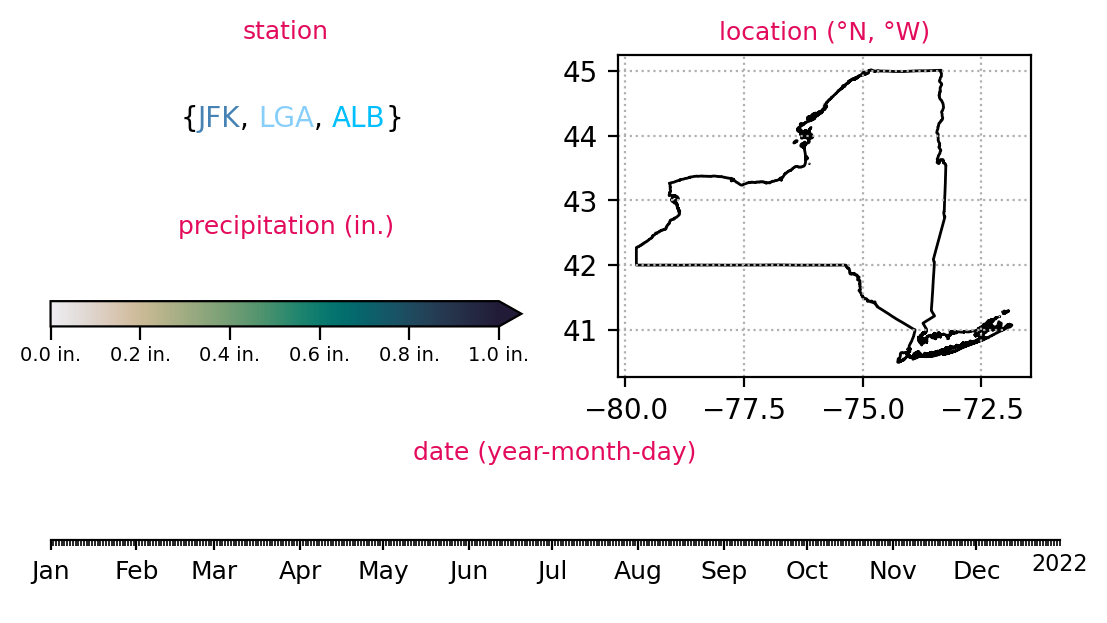

In [374]:

fig, axd = plt.subplot_mosaic([['stations', 'loc'], ['var', 'loc'], ['time', 'time']],
                              figsize=(6, 3), layout='compressed')
#{JFK, LGA, ALB}


axd['stations'].set_title("station",  color=pcd['fiber'], size=fs['small'])


st_str = [('{', 'k'), ('JFK', hh.airports['jfk_color']), (', ', 'k'), 
          ('LGA', hh.airports['lga_color']), (', ', 'k'), ('ALB', hh.airports['time_color']), ('}', 'k')]

#center text
t = axd['stations'].text(.5, .5, st_str[3][0], color=st_str[3][1], 
                         fontsize=fs['normal'], va='center', ha='center')
#right text
tr = t
for s, c in st_str[4:]:
    tr = axd['stations'].annotate(s, xy=(1,0), xycoords=tr, color=c,  
                                 fontsize=fs['normal'], va='bottom', ha='left')
#left text
tl = t
for s, c in st_str[:3][::-1]:
    tl = axd['stations'].annotate(s, xy=(0,0), xycoords=tl, color=c, 
                                  fontsize=fs['normal'], va='bottom', ha='right')
axd['stations'].axis('off')

axd['time'].set_title("date (year-month-day)", color=pcd['fiber'], size=fs['small'])
axd['time'].spines.bottom.set_position(('data', 0.5))
axd['time'].set(ylim=(0,1), yticks=[])
axd['time'].spines[['top', 'right', 'left']].set_visible(False)

ts = hh.get_timeseries(df, hh.airports['t_lat'], hh.airports['t_lon'])
ln,  = axd['time'].plot('DATE_DTYPE', "PRCP", data=ts, color = 'none')
axd['time'].set_xlim(xmin=ts['DATE_DTYPE'].min(), xmax=ts['DATE_DTYPE'].max())
axd['time'].xaxis.set_major_locator(mdates.MonthLocator())
axd['time'].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axd['time'].xaxis.set_minor_locator(mdates.DayLocator())
#axd['time'].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axd['time'].tick_params(labelsize=fs['small'])

axd['time'].annotate(ts['DATE_DTYPE'][0].dt.year.values[0], (1, .4), xycoords='axes fraction', 
                fontsize=fs['small']-1, va='top', ha='center')

axd['var'].set_title("precipitation (in.)", color=pcd['fiber'], size=fs['small'])

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cmocean.cm.rain
colorizer = mcolorizer.Colorizer(norm=norm, cmap=cmap)
sm = mcolorizer.ColorizingArtist(colorizer)
cax = axd['var'].inset_axes([0, .4, 1, .2])
cb = fig.colorbar(sm, cax=cax, extend='max', orientation='horizontal')
cb.ax.tick_params(labelsize=fs['script'], length=5, pad=2)
cb.ax.xaxis.set_major_formatter("{:0.1f} in.".format)
axd['var'].axis('off')

axd['loc'].set_title("location (°N, °W)",  color=pcd['fiber'], size=fs['small'])

mp = nyshp.plot(ax=axd['loc'],  facecolor='none', edgecolor='k')

for p_id in [('JFK INTL AP'), ('LAGUARDIA AP'), ('ALBANY INTL AP')]:
    nygeo[nygeo['NAME']==p_id].plot(marker ='s',edgecolor='x', ax=ax, markersize=60, lw=2)

axd['loc'].grid(ls=':')


In [309]:
ts

,ID,NAME,LATITUDE,LONGITUDE,DATE,TAVG,PRCP,DATE_DTYPE
0,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20220101,44.96,0.118110,2022-01-01
1,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20220102,39.02,0.070866,2022-01-02
0,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20220103,20.66,0.000000,2022-01-03
4,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20220104,17.24,0.000000,2022-01-04
6,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20220105,31.64,0.000000,2022-01-05
...,...,...,...,...,...,...,...,...
152,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221227,26.60,0.000000,2022-12-27
154,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221228,29.48,0.000000,2022-12-28
155,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221229,35.42,0.000000,2022-12-29
134,USW00014735,ALBANY INTL AP,42.7472,-73.7992,20221230,46.76,0.000000,2022-12-30


In [324]:
ts['DATE_DTYPE'][0].dt.year.values[0]

np.int32(2022)